In [1]:
# system
import os
import sys
import logging
import pickle
import multiprocessing as mp
from functools import partial
from collections import Cosunter

# externals 
import uproot
import torch
import pandas as pd
import awkward as ak
import numpy as np
from torch_geometric.data import DataLoader, Data
from matplotlib import pyplot as plt
import particle 
from matplotlib import colors
from matplotlib.patches import Ellipse
from particle import PDGID
from particle import Particle 
from particle.pdgid import is_meson
import mplhep as hep
import scipy.stats
hep.style.use("CMS")

In [2]:
def calc_dphi(phi1, phi2):
    """Computes phi2-phi1 given in range [-pi,pi]"""
    dphi = phi2 - phi1
    dphi[dphi > np.pi] -= 2*np.pi
    dphi[dphi < -np.pi] += 2*np.pi
    return dphi

def calc_eta(r, z):
    """Computes pseudorapidity
       (https://en.wikipedia.org/wiki/Pseudorapidity)
    """
    theta = np.arctan2(r, z)
    return -1. * np.log(np.tan(theta / 2.))

def zero_div(a,b):
    if b==0: return 0
    return a/b

def h1(array, xlabel, ylabel, bins=20, yscale='linear', title=''):
    fig = plt.figure(dpi=50)
    plt.hist(array)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.yscale(yscale)
    plt.title(title)
    plt.show()
    
def plot_cluster(ax, ieta, iphi, energy, r=[]):
    ibins = (np.arange(np.min(ieta)-2, np.max(ieta)+3, 1), 
             np.arange(np.min(iphi)-2, np.max(iphi)+3 ,1))
    h = ax.hist2d(ieta, iphi, bins=ibins, weights=energy, cmap='Reds', vmin=0, vmax=10)
    fontlist = ['small', 'x-small', 'xx-small']
    return h

In [3]:
def filter_gen_arrays(data, pt_min=10, ecal_min=0.05, hcal_min=0.05):
    tau_mask = (abs(data['gen_ID'])==15)
    pt_filter = ak.flatten(data['gen_pt'][tau_mask] > pt_min)
    data = data[pt_filter]
    tau_mask = tau_mask[pt_filter]
    pdgID = data['gen_ID']
    
    # masks for visible and invisible systems
    lepton_mask = ((abs(pdgID)==11) | # ele 
                   (abs(pdgID)==13))  # mu
    hadron_mask = ((abs(pdgID)==111) | # pi0
                   (abs(pdgID)==211) | # pi+
                   (abs(pdgID)==311) | # K0
                   (abs(pdgID)==321) | # K+
                   (abs(pdgID)==130) | # K0S
                   (abs(pdgID)==310))  # K0L
    vis_mask = hadron_mask
    neutrino_mask = ((abs(pdgID)==12) | # nu_e
                     (abs(pdgID)==14) | # nu_mu
                     (abs(pdgID)==16))  # nu_tau

    tau = {'pt': data['gen_pt'][tau_mask][:,0],
           'eta': data['gen_eta'][tau_mask][:,0],
           'phi': data['gen_phi'][tau_mask][:,0],
           'mass': data['gen_mass'][tau_mask][:,0],
           'energy': data['gen_energy'][tau_mask][:,0],
           'vxy': data['gen_vxy'][tau_mask][:,0],
           'vz': data['gen_vz'][tau_mask][:,0]}
    vis = {'ID': data['gen_ID'][vis_mask],
           'pt': data['gen_pt'][vis_mask],
           'eta': data['gen_eta'][vis_mask],
           'phi': data['gen_phi'][vis_mask],
           'mass': data['gen_mass'][vis_mask],
           'energy': data['gen_energy'][vis_mask],
           'vxy': data['gen_vxy'][vis_mask],
           'vz': data['gen_vz'][vis_mask]}
    inv = {'pt': data['gen_pt'][neutrino_mask],
           'eta': data['gen_eta'][neutrino_mask],
           'phi': data['gen_phi'][neutrino_mask],
           'mass': data['gen_mass'][neutrino_mask],
           'energy': data['gen_energy'][neutrino_mask],
           'vxy': data['gen_vxy'][neutrino_mask],
           'vz': data['gen_vz'][neutrino_mask]}
    
    # raw sim_hit quantities
    ee_mask = (data['sim_hits_ee_energy'] > ecal_min)
    eb_mask = (data['sim_hits_eb_energy'] > ecal_min)
    es_mask = (data['sim_hits_es_energy'] > ecal_min)
    #hcal_mask = (data['sim_hits_hcal_energy'] > hcal_min)
    sim_hits =  {'ee': {'detid': data['sim_hits_ee_detid'][ee_mask], 
                        'energy': data['sim_hits_ee_energy'][ee_mask],
                        'ix': data['sim_hits_ee_ix'][ee_mask],
                        'iy': data['sim_hits_ee_iy'][ee_mask],
                        'rho': data['sim_hits_ee_rho'][ee_mask],
                        'eta': data['sim_hits_ee_eta'][ee_mask],
                        'phi': data['sim_hits_ee_phi'][ee_mask],
                        'time': data['sim_hits_ee_time'][ee_mask]
                       },
                 'eb': {'detid': data['sim_hits_eb_detid'][eb_mask],
                        'energy': data['sim_hits_eb_energy'][eb_mask],
                        'ieta': data['sim_hits_eb_ieta'][eb_mask],
                        'iphi': data['sim_hits_eb_iphi'][eb_mask],
                        'rho': data['sim_hits_eb_rho'][eb_mask],
                        'eta': data['sim_hits_eb_eta'][eb_mask],
                        'phi': data['sim_hits_eb_phi'][eb_mask],
                        'time': data['sim_hits_eb_time'][eb_mask]
                       },
                 'es': {'detid': data['sim_hits_es_detid'][es_mask],
                        'energy': data['sim_hits_es_energy'][es_mask],
                        'six': data['sim_hits_es_six'][es_mask],
                        'siy': data['sim_hits_es_siy'][es_mask],
                        'rho': data['sim_hits_es_rho'][es_mask],
                        'eta': data['sim_hits_es_eta'][es_mask],
                        'phi': data['sim_hits_es_phi'][es_mask],
                        'time': data['sim_hits_es_time'][es_mask]
                       }
                }
    
    # derived sim_hit quantities
    for sd in sim_hits.keys():
        sim_hits[sd]['x'] = sim_hits[sd]['rho'] * np.cos(sim_hits[sd]['phi'])
        sim_hits[sd]['y'] = sim_hits[sd]['rho'] * np.sin(sim_hits[sd]['phi'])
        sim_hits[sd]['z'] = (sim_hits[sd]['rho'] / 
                             np.tan(2*np.arctan(np.exp(-1*sim_hits[sd]['eta']))))
   
    return {'tau': tau, 'vis': vis, 'inv': inv, 'sim_hits': sim_hits}

In [4]:
def filter_reco_arrays(data, ecal_min=0.05, hcal_min = 0.05):
    ee_mask = (data['rec_hits_ee_energy'] > ecal_min)
    eb_mask = (data['rec_hits_eb_energy'] > ecal_min)
    es_mask = (data['rec_hits_es_energy'] > ecal_min)
    hbhe_mask = (data['rec_hits_hbhe_energy'] > hcal_min)
    hf_mask = (data['rec_hits_hf_energy'] > hcal_min)
    ho_mask = (data['rec_hits_ho_energy'] > hcal_min)
    rec_hits = {'ee': {'detid': data['rec_hits_ee_detid'][ee_mask], 
                       'energy': data['rec_hits_ee_energy'][ee_mask],
                       'ix': data['rec_hits_ee_ix'][ee_mask],
                       'iy': data['rec_hits_ee_iy'][ee_mask],
                       'rho': data['rec_hits_ee_rho'][ee_mask],
                       'eta': data['rec_hits_ee_eta'][ee_mask],
                       'phi': data['rec_hits_ee_phi'][ee_mask],
                       'time': data['rec_hits_ee_time'][ee_mask]
                      },
                'eb': {'detid': data['rec_hits_eb_detid'][eb_mask],
                       'energy': data['rec_hits_eb_energy'][eb_mask],
                       'ieta': data['rec_hits_eb_ieta'][eb_mask],
                       'iphi': data['rec_hits_eb_iphi'][eb_mask],
                       'rho': data['rec_hits_eb_rho'][eb_mask],
                       'eta': data['rec_hits_eb_eta'][eb_mask],
                       'phi': data['rec_hits_eb_phi'][eb_mask],
                       'time': data['rec_hits_eb_time'][eb_mask]
                      },
                'es': {'detid': data['rec_hits_es_detid'][es_mask],
                       'energy': data['rec_hits_es_energy'][es_mask],
                       'six': data['rec_hits_es_six'][es_mask],
                       'siy': data['rec_hits_es_siy'][es_mask],
                       'rho': data['rec_hits_es_rho'][es_mask],
                       'eta': data['rec_hits_es_eta'][es_mask],
                       'phi': data['rec_hits_es_phi'][es_mask],
                       'time': data['rec_hits_es_time'][es_mask]
                      },
                'hbhe': {'detid': data['rec_hits_hbhe_detid'][hbhe_mask],
                         'energy': data['rec_hits_hbhe_energy'][hbhe_mask],
                         'ieta': data['rec_hits_hbhe_ieta'][hbhe_mask],
                         'iphi': data['rec_hits_hbhe_iphi'][hbhe_mask],
                         'rho': data['rec_hits_hbhe_rho'][hbhe_mask],
                         'eta': data['rec_hits_hbhe_eta'][hbhe_mask],
                         'phi': data['rec_hits_hbhe_phi'][hbhe_mask],
                         'time': data['rec_hits_hbhe_time'][hbhe_mask]

                        },
                'hf': {'detid': data['rec_hits_hf_detid'][hf_mask],
                       'energy': data['rec_hits_hf_energy'][hf_mask],
                       'ieta': data['rec_hits_hf_ieta'][hf_mask],
                       'iphi': data['rec_hits_hf_iphi'][hf_mask],
                       'rho': data['rec_hits_hf_rho'][hf_mask],
                       'eta': data['rec_hits_hf_eta'][hf_mask],
                       'phi': data['rec_hits_hf_phi'][hf_mask],
                       'time': data['rec_hits_hf_time'][hf_mask]

                      },
                'ho': {'detid': data['rec_hits_ho_detid'][ho_mask],
                       'energy': data['rec_hits_ho_energy'][ho_mask],
                       'ieta': data['rec_hits_ho_ieta'][ho_mask],
                       'iphi': data['rec_hits_ho_iphi'][ho_mask],
                       'rho': data['rec_hits_ho_rho'][ho_mask],
                       'eta': data['rec_hits_ho_eta'][ho_mask],
                       'phi': data['rec_hits_ho_phi'][ho_mask],
                       'time': data['rec_hits_ho_time'][ho_mask]

                      },
           }
    
    # derived rec_hit quantities
    for sd in rec_hits.keys():
        rec_hits[sd]['x'] = rec_hits[sd]['rho'] * np.cos(rec_hits[sd]['phi'])
        rec_hits[sd]['y'] = rec_hits[sd]['rho'] * np.sin(rec_hits[sd]['phi'])
        rec_hits[sd]['z'] = (rec_hits[sd]['rho'] / 
                             np.tan(2*np.arctan(np.exp(-1*rec_hits[sd]['eta']))))
        
    return {'rec_hits': rec_hits}

In [5]:
def debug_event(i, sim, rec, vis, zoom_rec=False):
    print('simhits in ee:', len(sim['ee']['detid'][i]))
    print('simhits in eb:', len(sim['eb']['detid'][i]))
    print('simhits in es:', len(sim['es']['detid'][i]))
    print('rechits in ee:', len(rec['ee']['detid'][i]))
    print('rechits in eb:', len(rec['eb']['detid'][i]))
    print('rechits in es:', len(rec['es']['detid'][i]))

    sim_detid = sim['eb']['detid'][i]
    sim_ieta = sim['eb']['ieta'][i]
    sim_iphi = sim['eb']['iphi'][i]
    sim_energy = sim['eb']['energy'][i]
    rec_detid = rec['eb']['detid'][i]
    rec_ieta = rec['eb']['ieta'][i]
    rec_iphi = rec['eb']['iphi'][i]
    rec_energy = rec['eb']['energy'][i]
    vis_ID = vis['ID'][i]
    print(vis_ID)
    vis_eta = vis['eta'][i]
    vis_phi = vis['phi'][i]
    vis_ieta = [0]*len(vis_eta)
    vis_iphi = [0]*len(vis_phi)
    eb_ieta = np.linspace(-1.479, 1.479, 171)
    eb_iphi = np.linspace(-np.pi, np.pi, 361)
    for v in range(len(vis_eta)):
        for idx, (low, high) in enumerate(list(zip(eb_ieta[:-1], eb_ieta[1:]))):
            if (vis_eta[v] < high) and (vis_eta[v] >= low):
                print('eta:', vis_eta[v], 'in bin', idx-85)
                vis_ieta[v] = idx-85
        for idx, (low, high) in enumerate(list(zip(eb_iphi[:-1], eb_iphi[1:]))):
            if (vis_phi[v] < high) and (vis_phi[v] >= low):
                print('phi:', vis_phi[v], 'in bin', idx)
                vis_iphi[v] = idx
                      
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,6), dpi=100)
    plot_cluster(axs[0], sim_ieta, sim_iphi, np.exp(sim_energy))
    plot_cluster(axs[1], rec_ieta, rec_iphi, np.exp(rec_energy))
    xlim = [axs[0].get_xlim()[0]-30, axs[0].get_xlim()[1]+30]
    ylim = [axs[0].get_ylim()[0]-30, axs[0].get_ylim()[1]+30]
    for v in range(len(vis_ieta)):
        print(vis_ieta[v], vis_iphi[v])
        axs[1].add_patch(Ellipse(xy=(vis_ieta[v], vis_iphi[v]), width=3, height=3, color="cyan", fill=False, lw=1, zorder=10))
    if zoom_rec:
        axs[1].set_xlim(xlim)
        axs[1].set_ylim(ylim)
    plt.show()

In [6]:
def truth_match_hits(e, sim, rec):
    stats = {'total_sim_hits':  0,
             'matched_sim_hits': 0,
             'total_rec_hits': 0,
             'matched_rec_hits': 0}
    
    # loop over subdetectors, build dataframe in each
    df_list = []
    for sd in sim.keys(): 
        
        # grab binned coordinates for the subdetector
        ix = 'ix' if 'ix' in sim[sd].keys() else 'ieta'
        if 'six' in sim[sd].keys(): ix = 'six'
        iy = 'iy' if 'iy' in sim[sd].keys() else 'iphi'
        if 'siy' in sim[sd].keys(): iy = 'siy'
        
        # build dataframe for rec hits
        n_rec = len(rec[sd]['detid'][e])
        df_rec = pd.DataFrame({'x': rec[sd]['x'][e], 'ix': rec[sd][ix][e],
                               'y': rec[sd]['y'][e], 'iy': rec[sd][iy][e],
                               'z': rec[sd]['z'][e], 'ID': rec[sd]['detid'][e],
                               'energy': rec[sd]['energy'][e],
                               'temp': np.ones(n_rec),
                              })
        df_rec = df_rec.drop_duplicates('ID', keep='first')
        stats['total_rec_hits'] += len(df_rec)
        
        # build dataframe for sim hits
        n_sim = len(sim[sd]['detid'][e])
        df_sim = pd.DataFrame({'x': sim[sd]['x'][e], 'ix': sim[sd][ix][e],
                               'y': sim[sd]['y'][e], 'iy': sim[sd][iy][e],
                               'z': sim[sd]['z'][e], 'ID': sim[sd]['detid'][e],
                               'energy': sim[sd]['energy'][e],
                               'temp': np.ones(n_sim),
                              })
        df_sim = df_sim.drop_duplicates('ID', keep='first')
        stats['total_sim_hits'] += len(df_sim)
        
        # form all possible sim-rec hit pairs 
        df = df_rec.reset_index().merge(df_sim.reset_index(), 
                                        on='temp', suffixes=('_rec', '_sim'))
        df['subdetector'] = sd
        
        # matching definition: within 2 ix/iy units from a simhit
        df['matched'] = ((abs(df['ix_rec'] - df['ix_sim']) < 3) &
                         (abs(df['iy_rec'] - df['iy_sim']) < 3))
        
        # keep relevant columns, add to whole-event dataframe
        keep_cols = ['ix_rec', 'iy_rec', 'x_rec', 'y_rec', 'z_rec',
                     'energy_rec', 'subdetector', 'matched']
        df_list.append(df.drop_duplicates('ID_rec', keep='first')[keep_cols])
        
        # determine which hits were matched
        mask = (df['matched']==True)
        if (np.sum(mask)==0): continue
        stats['matched_sim_hits'] += len(np.unique(df[mask].ID_sim))
        stats['matched_rec_hits'] += len(np.unique(df[mask].ID_rec))
    
    stats['sim_match_fraction'] = zero_div(stats['matched_sim_hits'],
                                           stats['total_sim_hits'])
    stats['rec_match_fraction'] = zero_div(stats['matched_rec_hits'],
                                           stats['total_rec_hits'])

    event = pd.concat(df_list)
    return event, stats

In [7]:
os.listdir('skims')

['ThreeProngsNoPi0.p',
 'ThreeProngsOnePi0.p',
 'OneProngTwoPi0.p',
 'OneProngNoPi0.p',
 'OneProngOnePi0.p']

In [14]:
f = 'skims/ThreeProngsOnePi0.p'
with open(f, 'rb') as handle:
    data = pickle.load(handle)

gen = filter_gen_arrays(data['gen_arrays'])
reco = filter_reco_arrays(data['reco_arrays'])
sim = gen['sim_hits']
rec = reco['rec_hits']  
tau = gen['tau']
vis = gen['vis']
inv = gen['inv']

# loop over events 
total_sim, total_rec = [], []
sim_effs, rec_effs = [], [] 
for e in range(len(sim['ee']['detid'])): 
    event, stats = truth_match_hits(e, sim, rec)
    sim_effs.append(stats['sim_match_fraction'])
    rec_effs.append(stats['rec_match_fraction'])
    total_sim.append(stats['total_sim_hits'])
    total_rec.append(stats['total_rec_hits'])

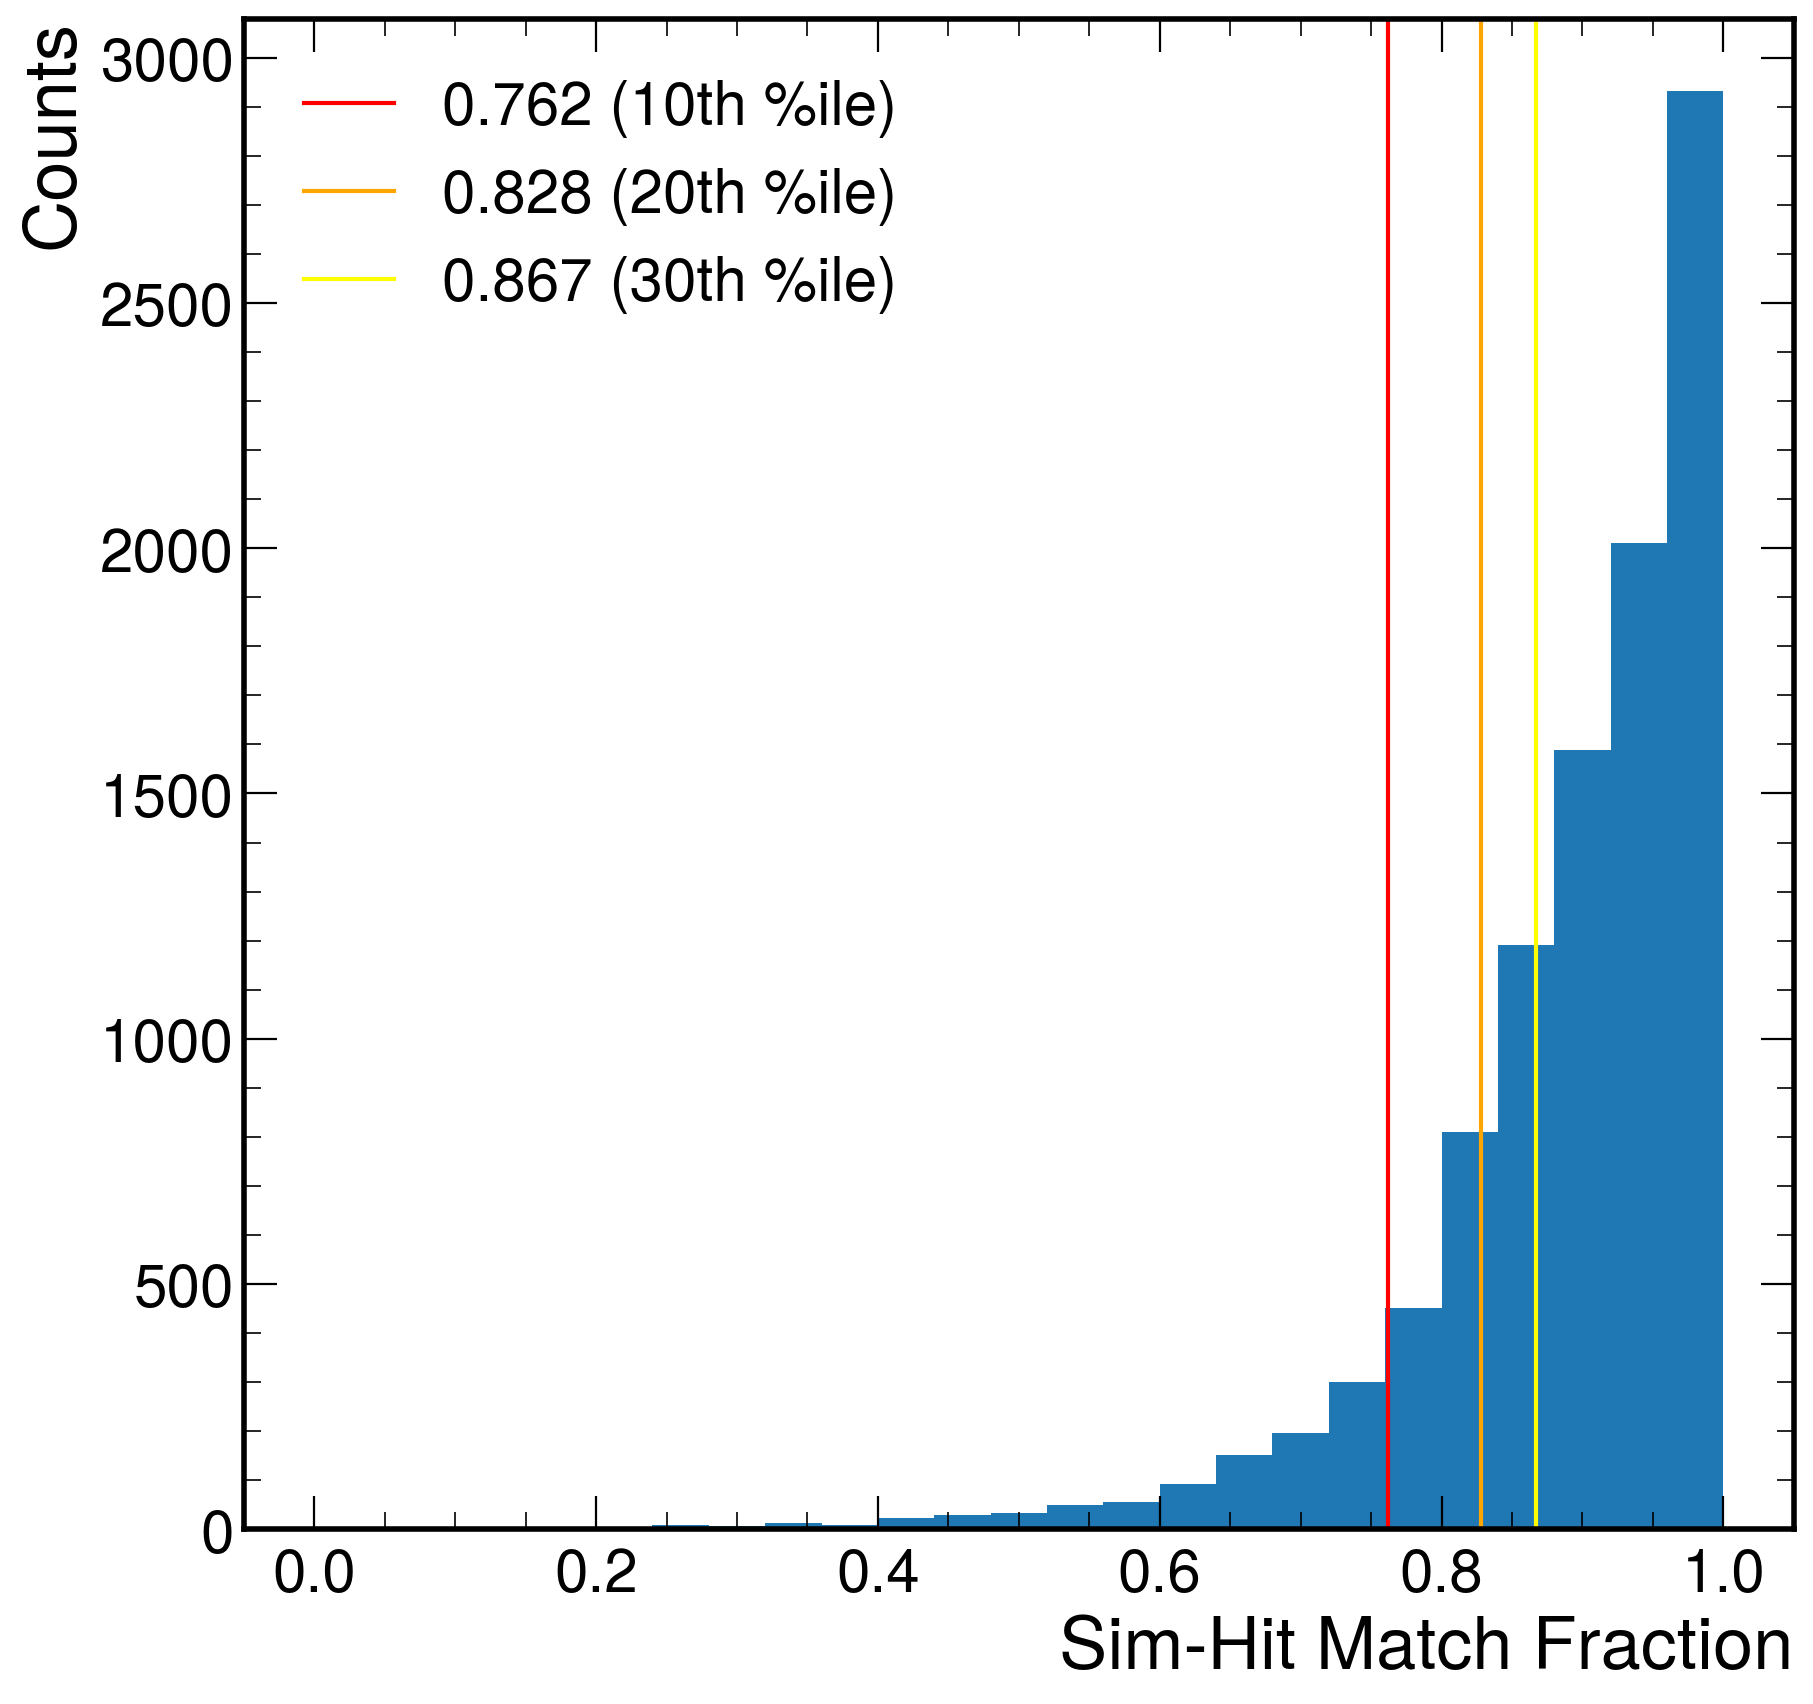

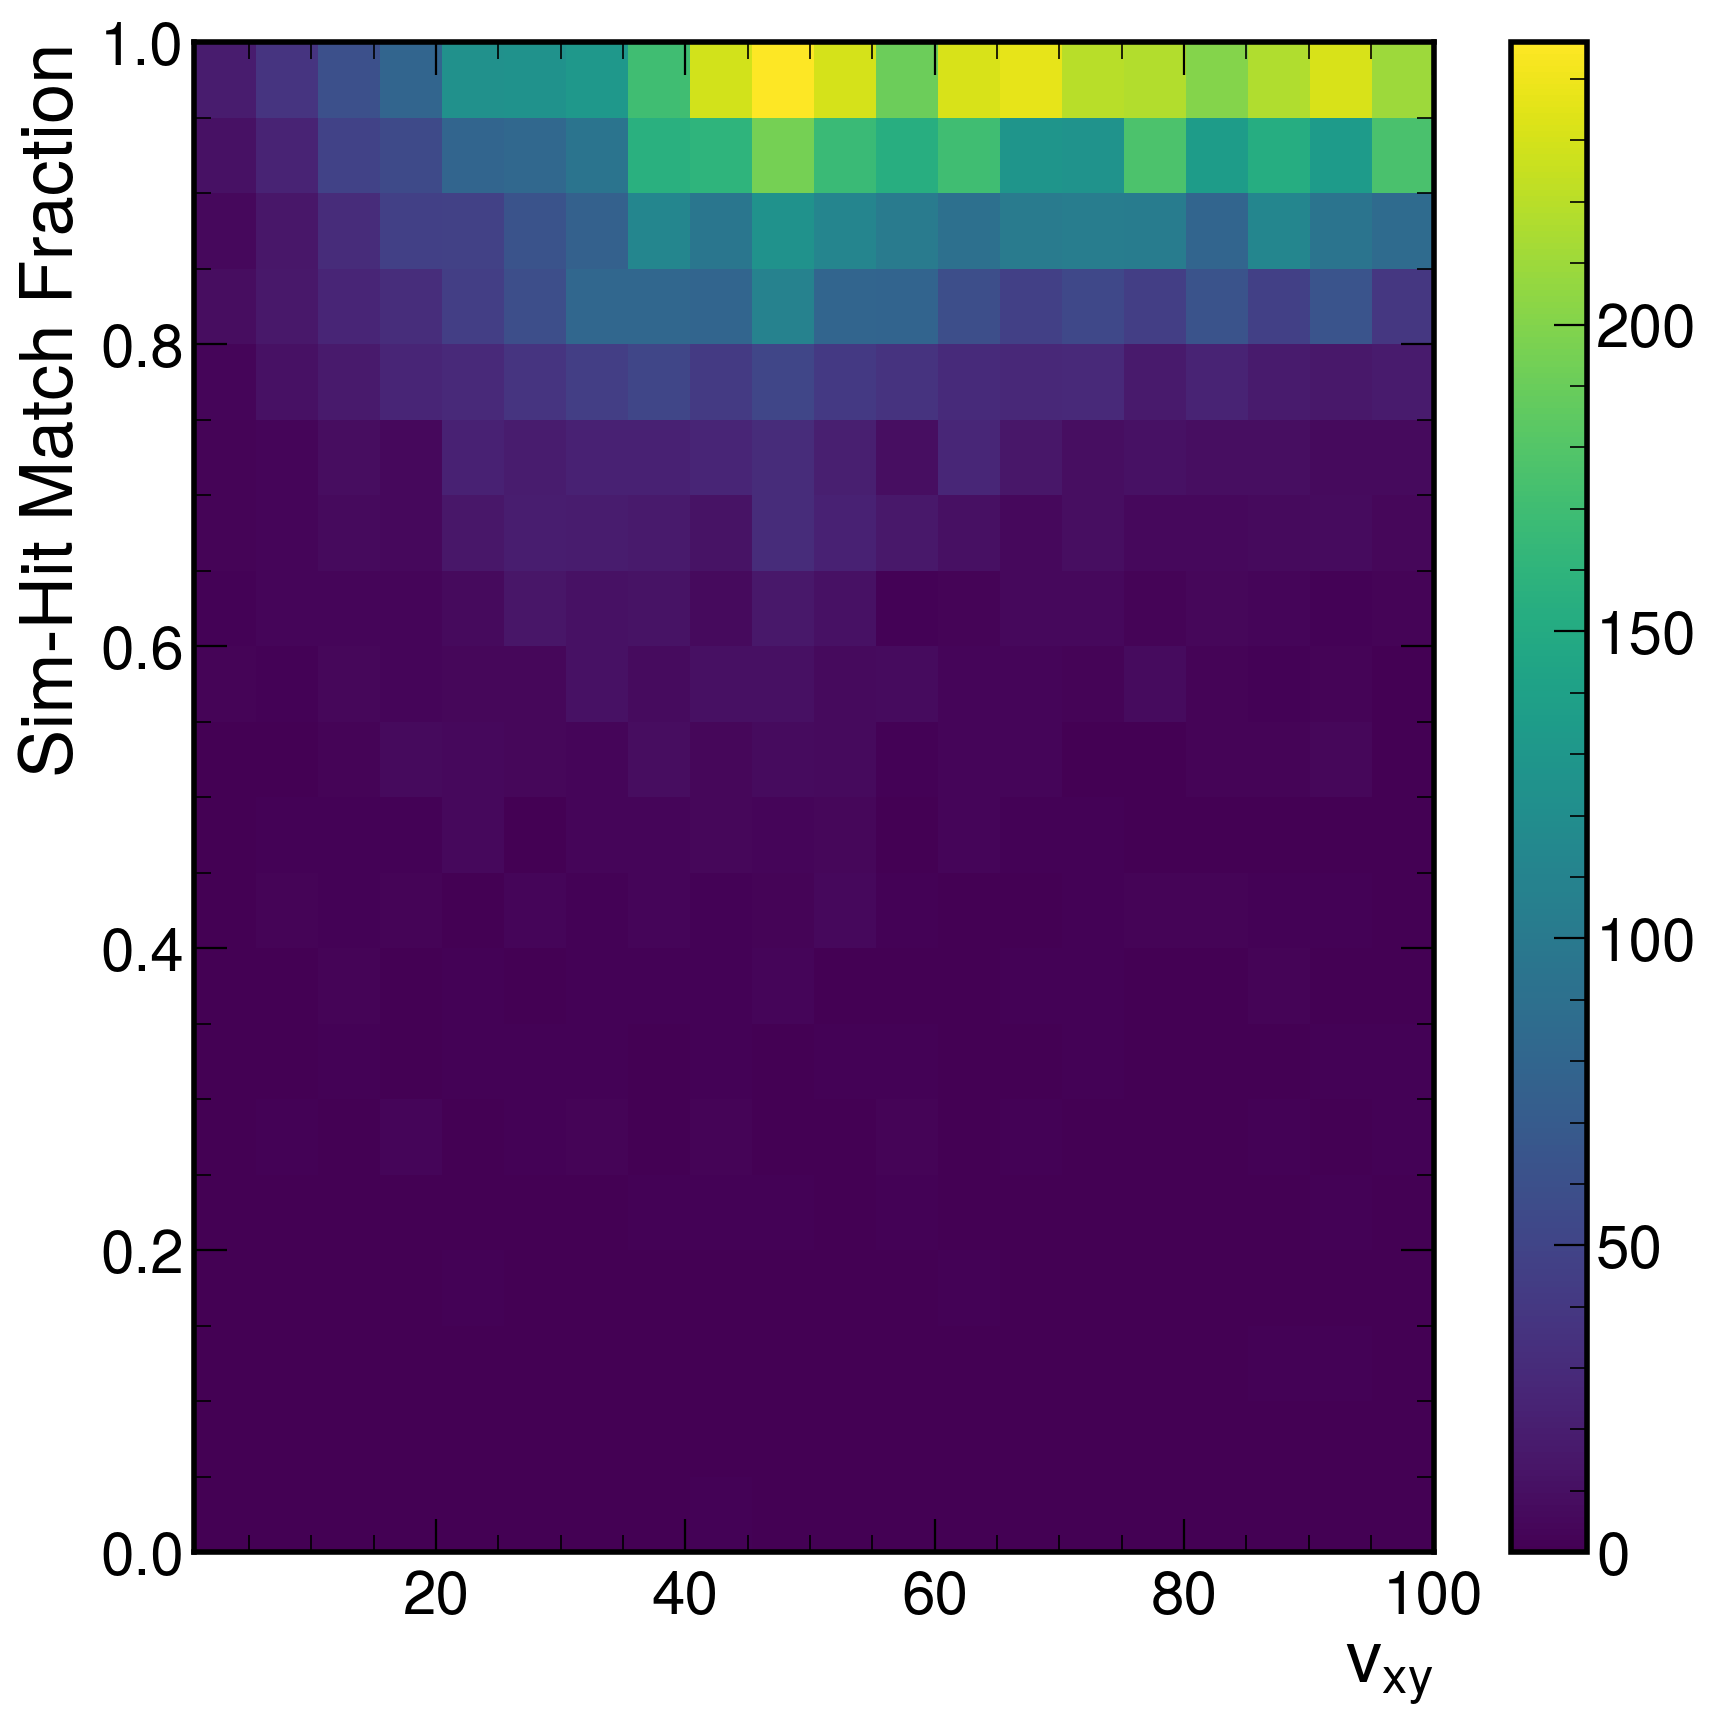

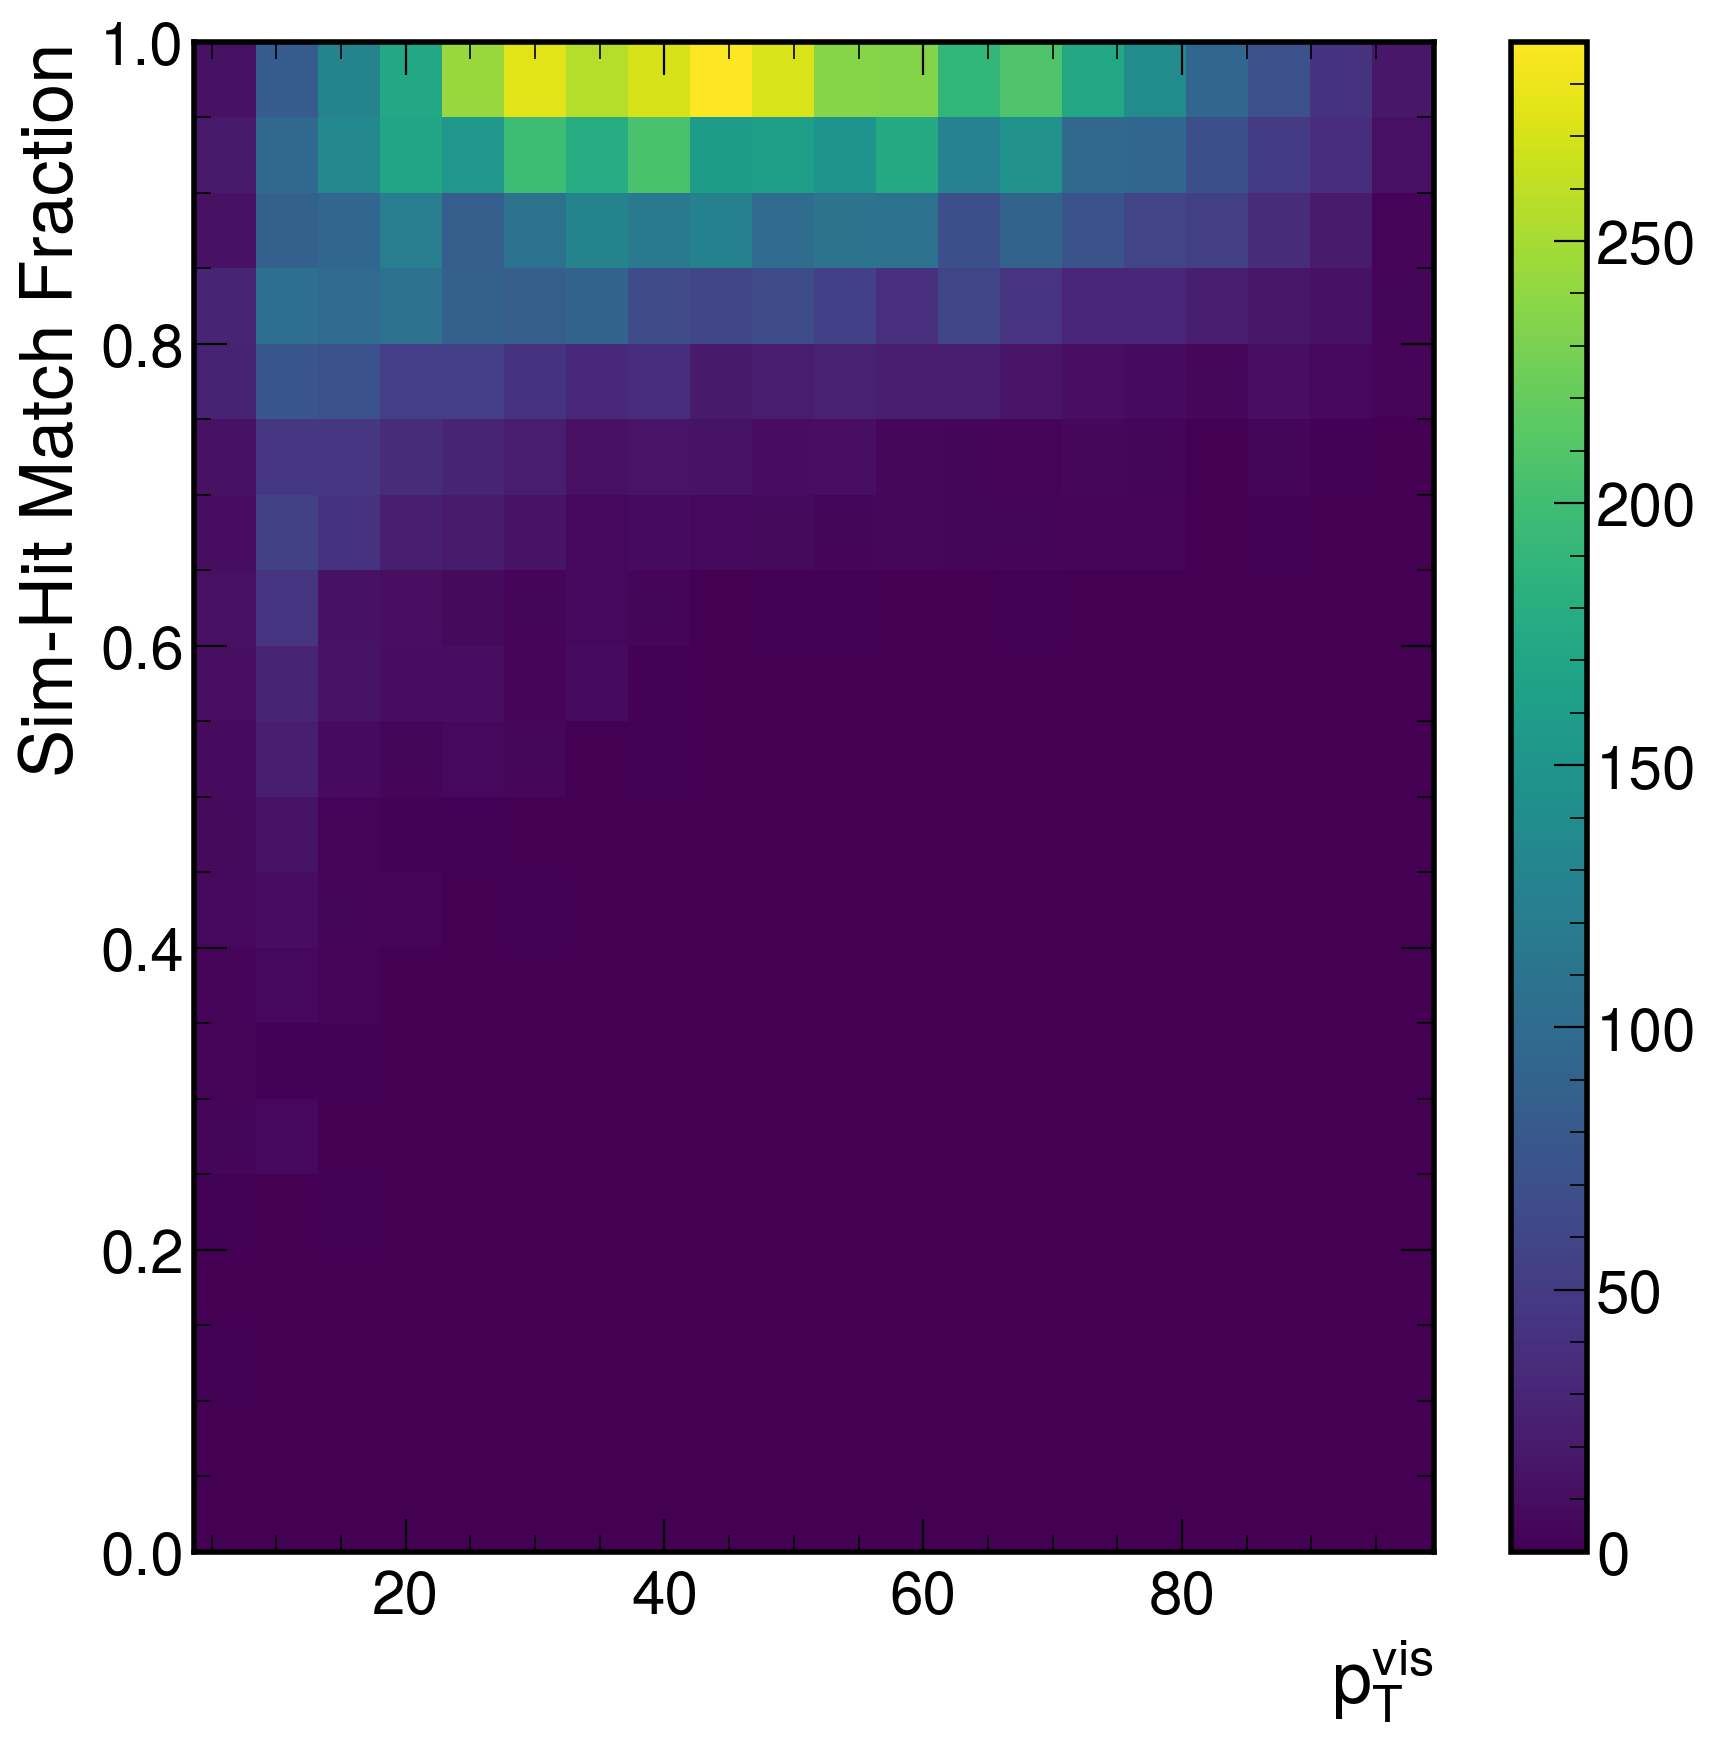

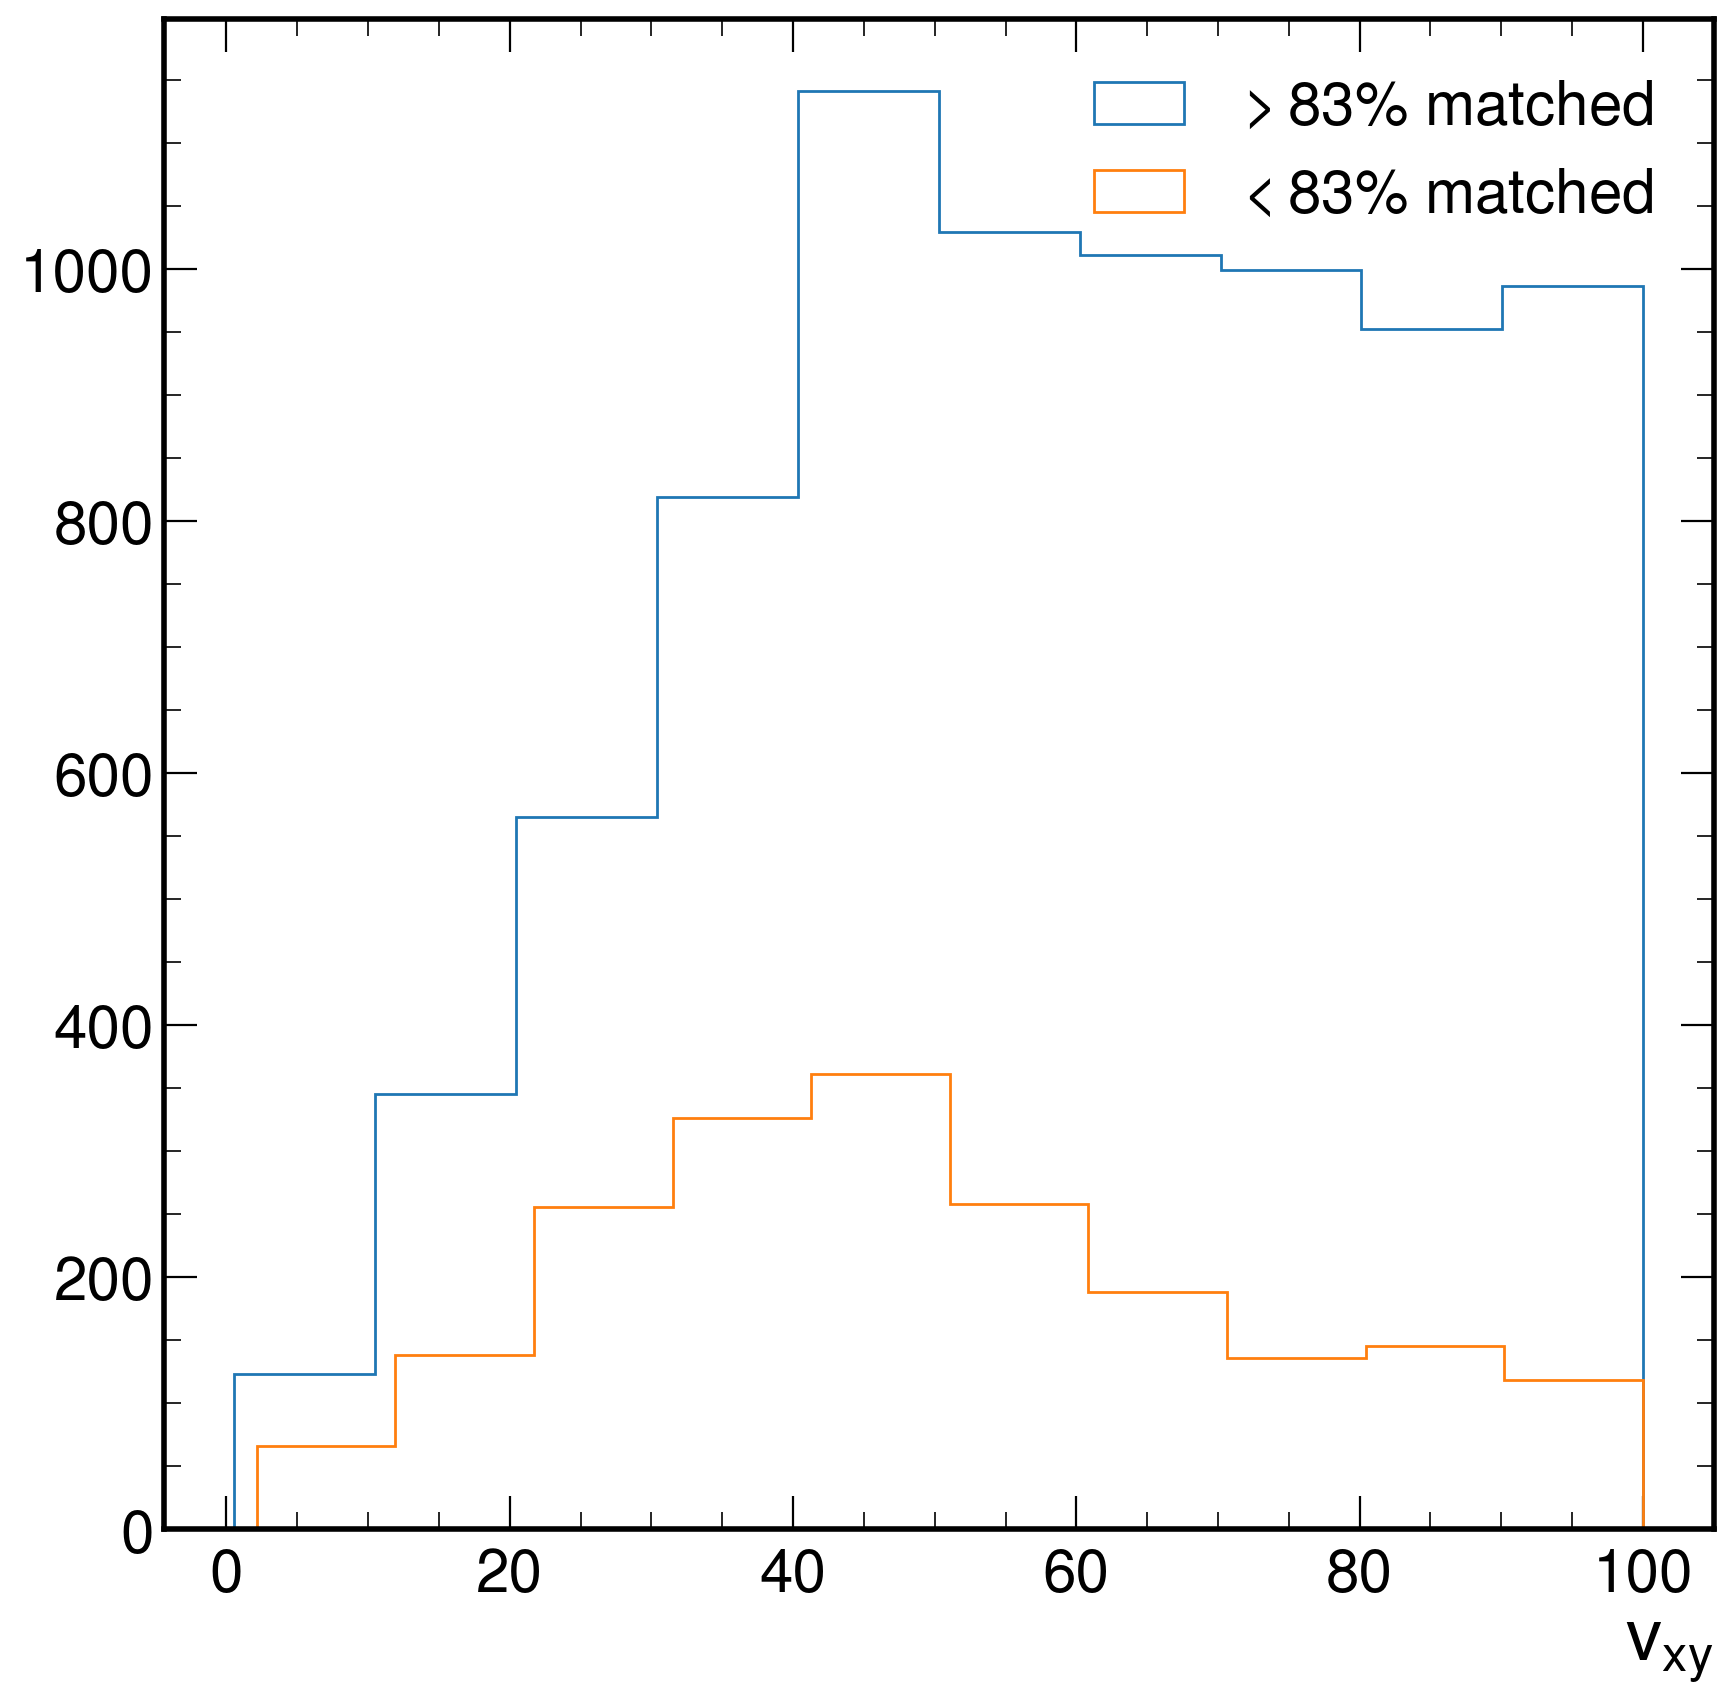

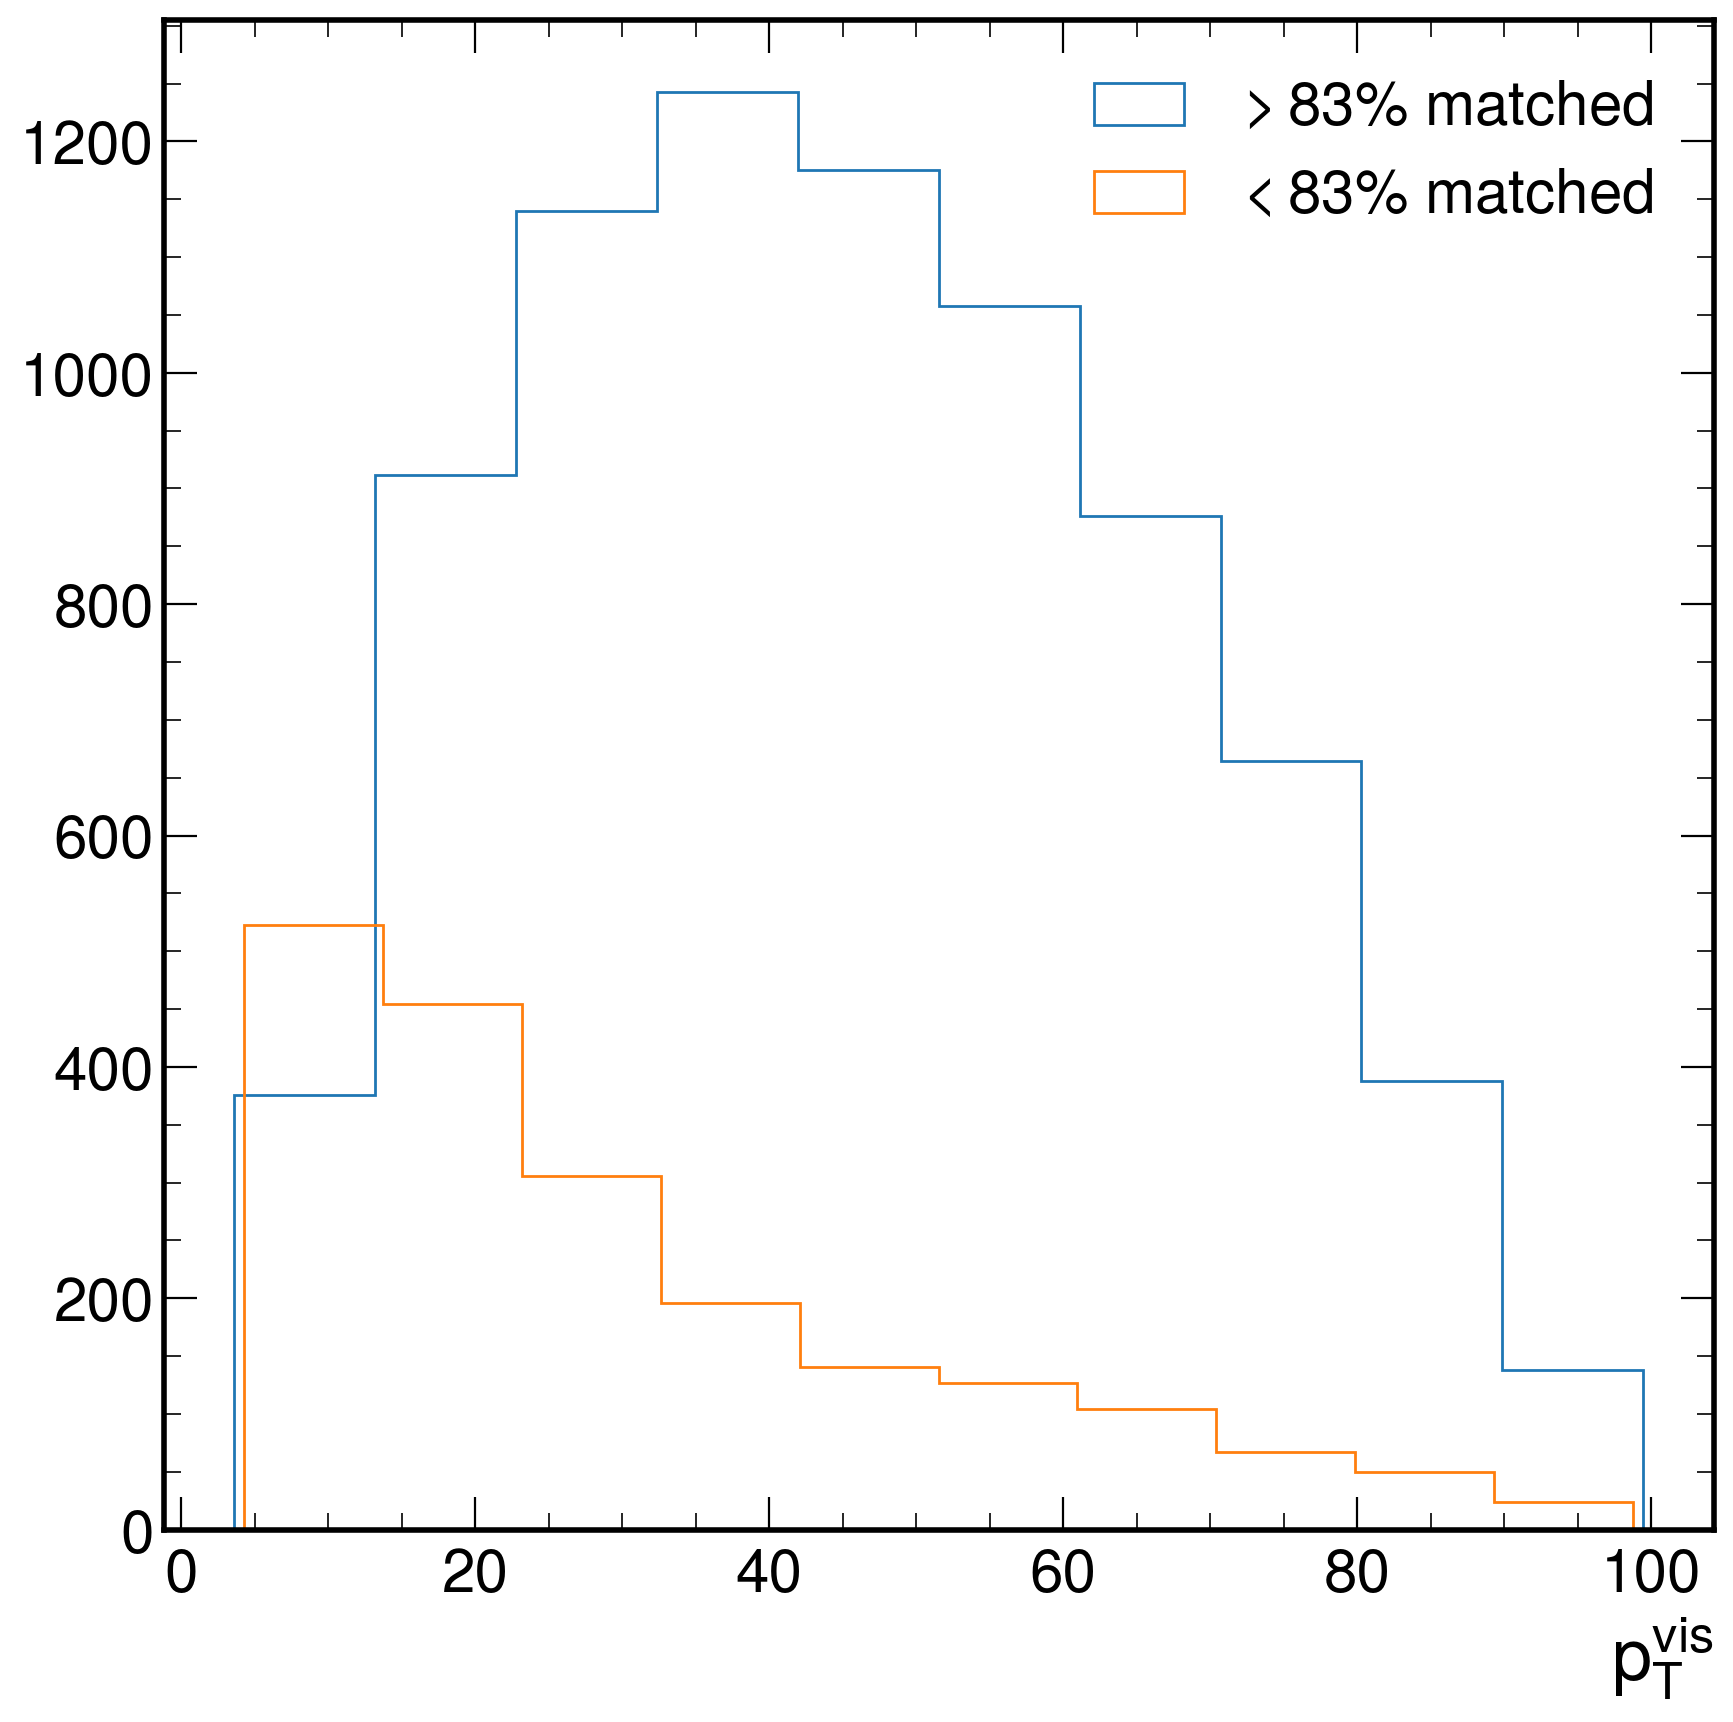

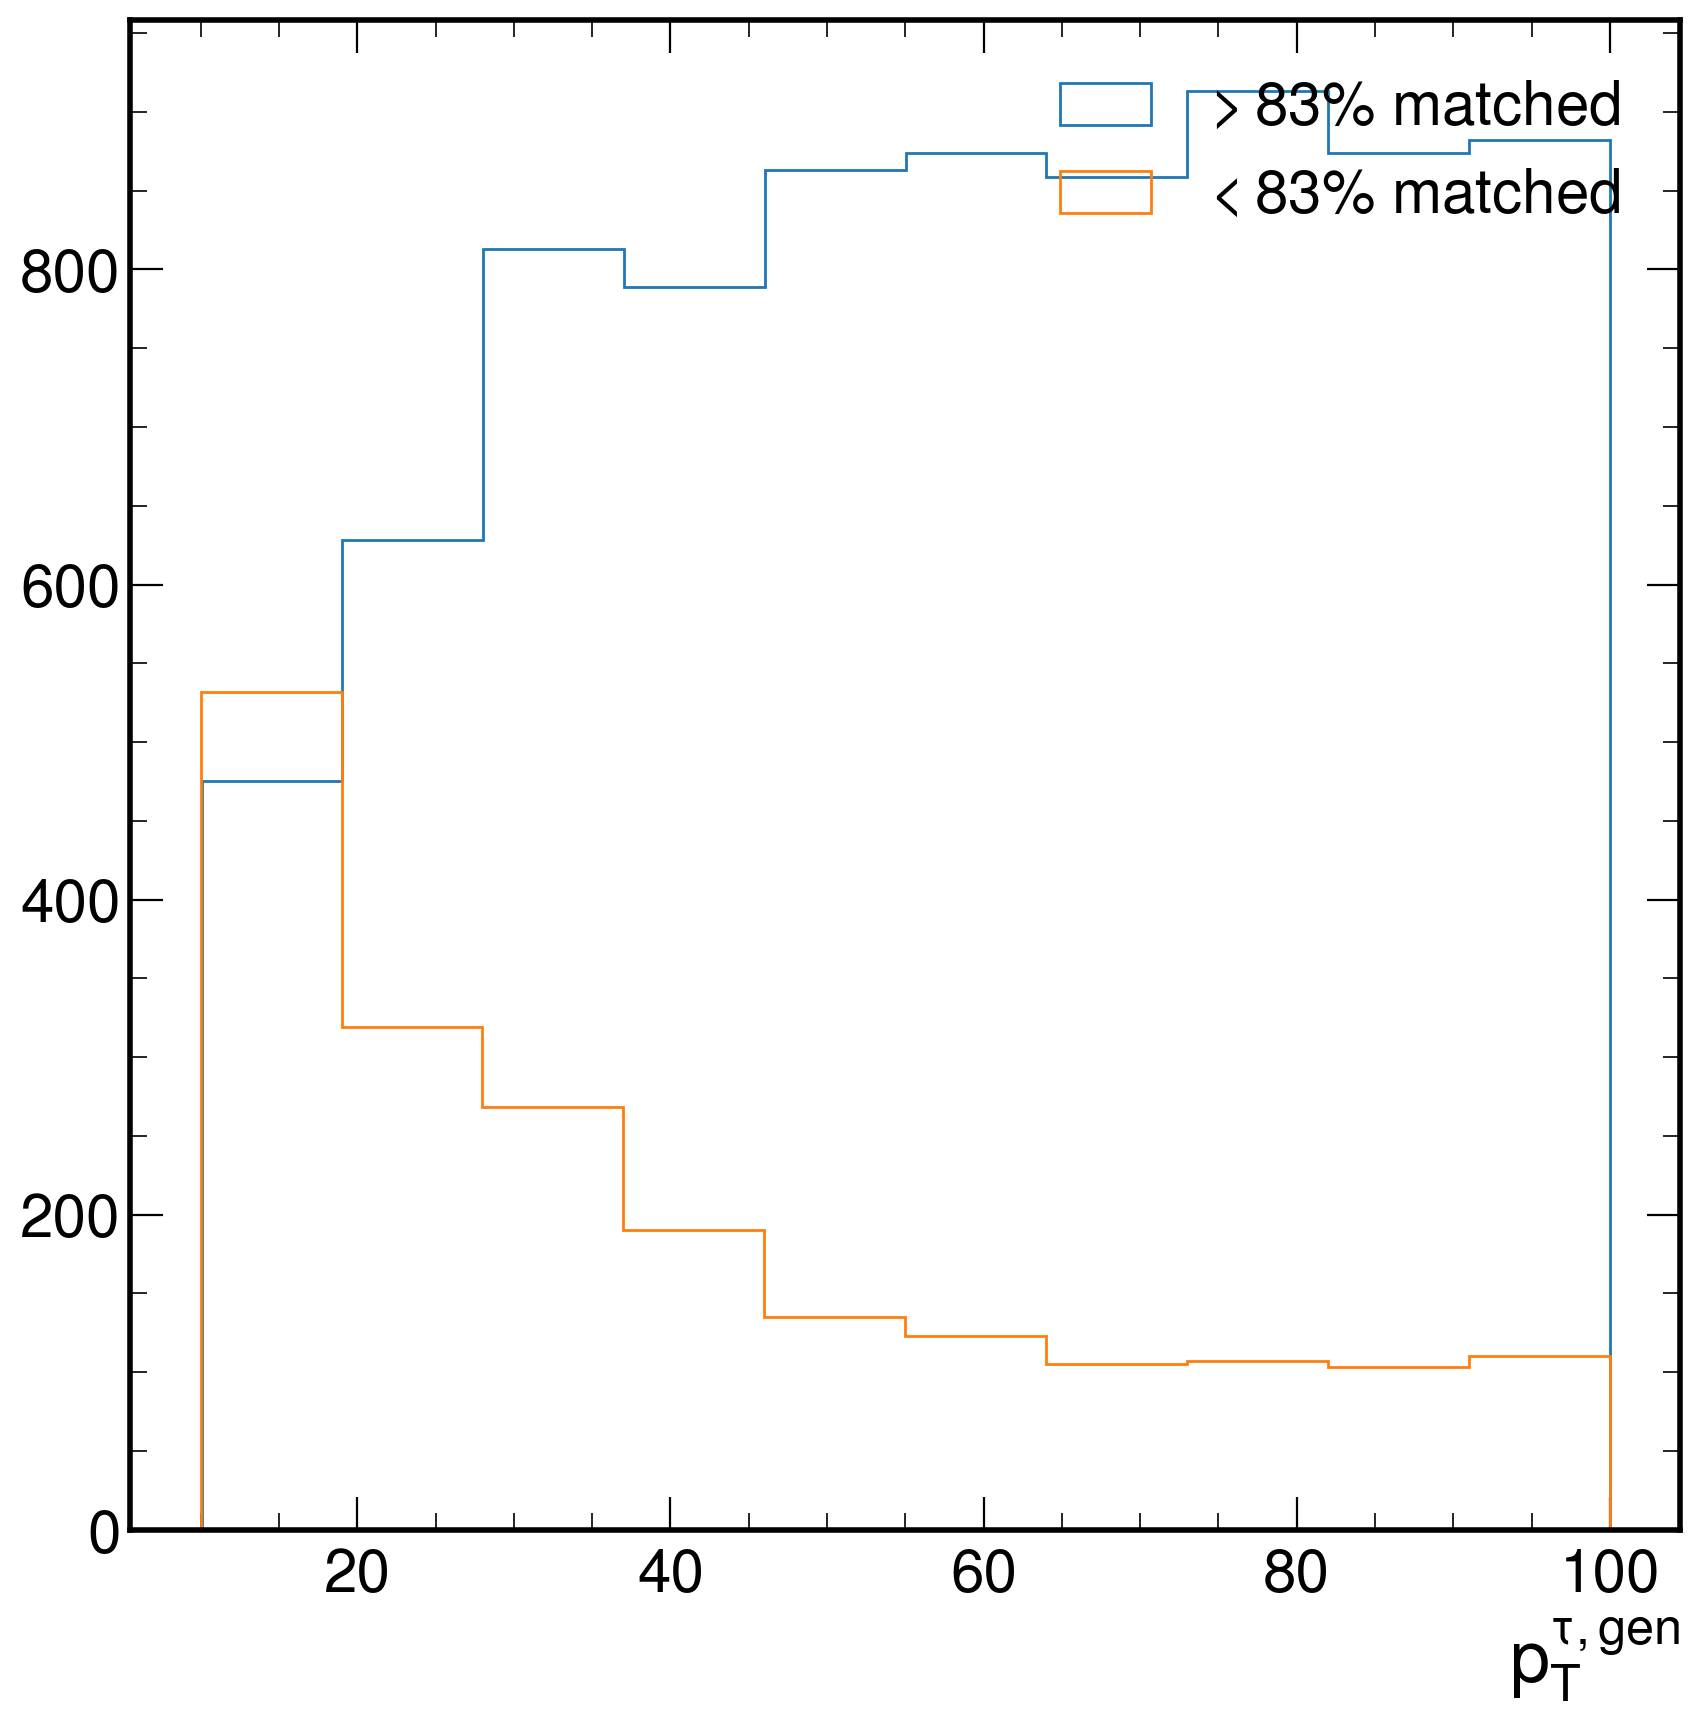

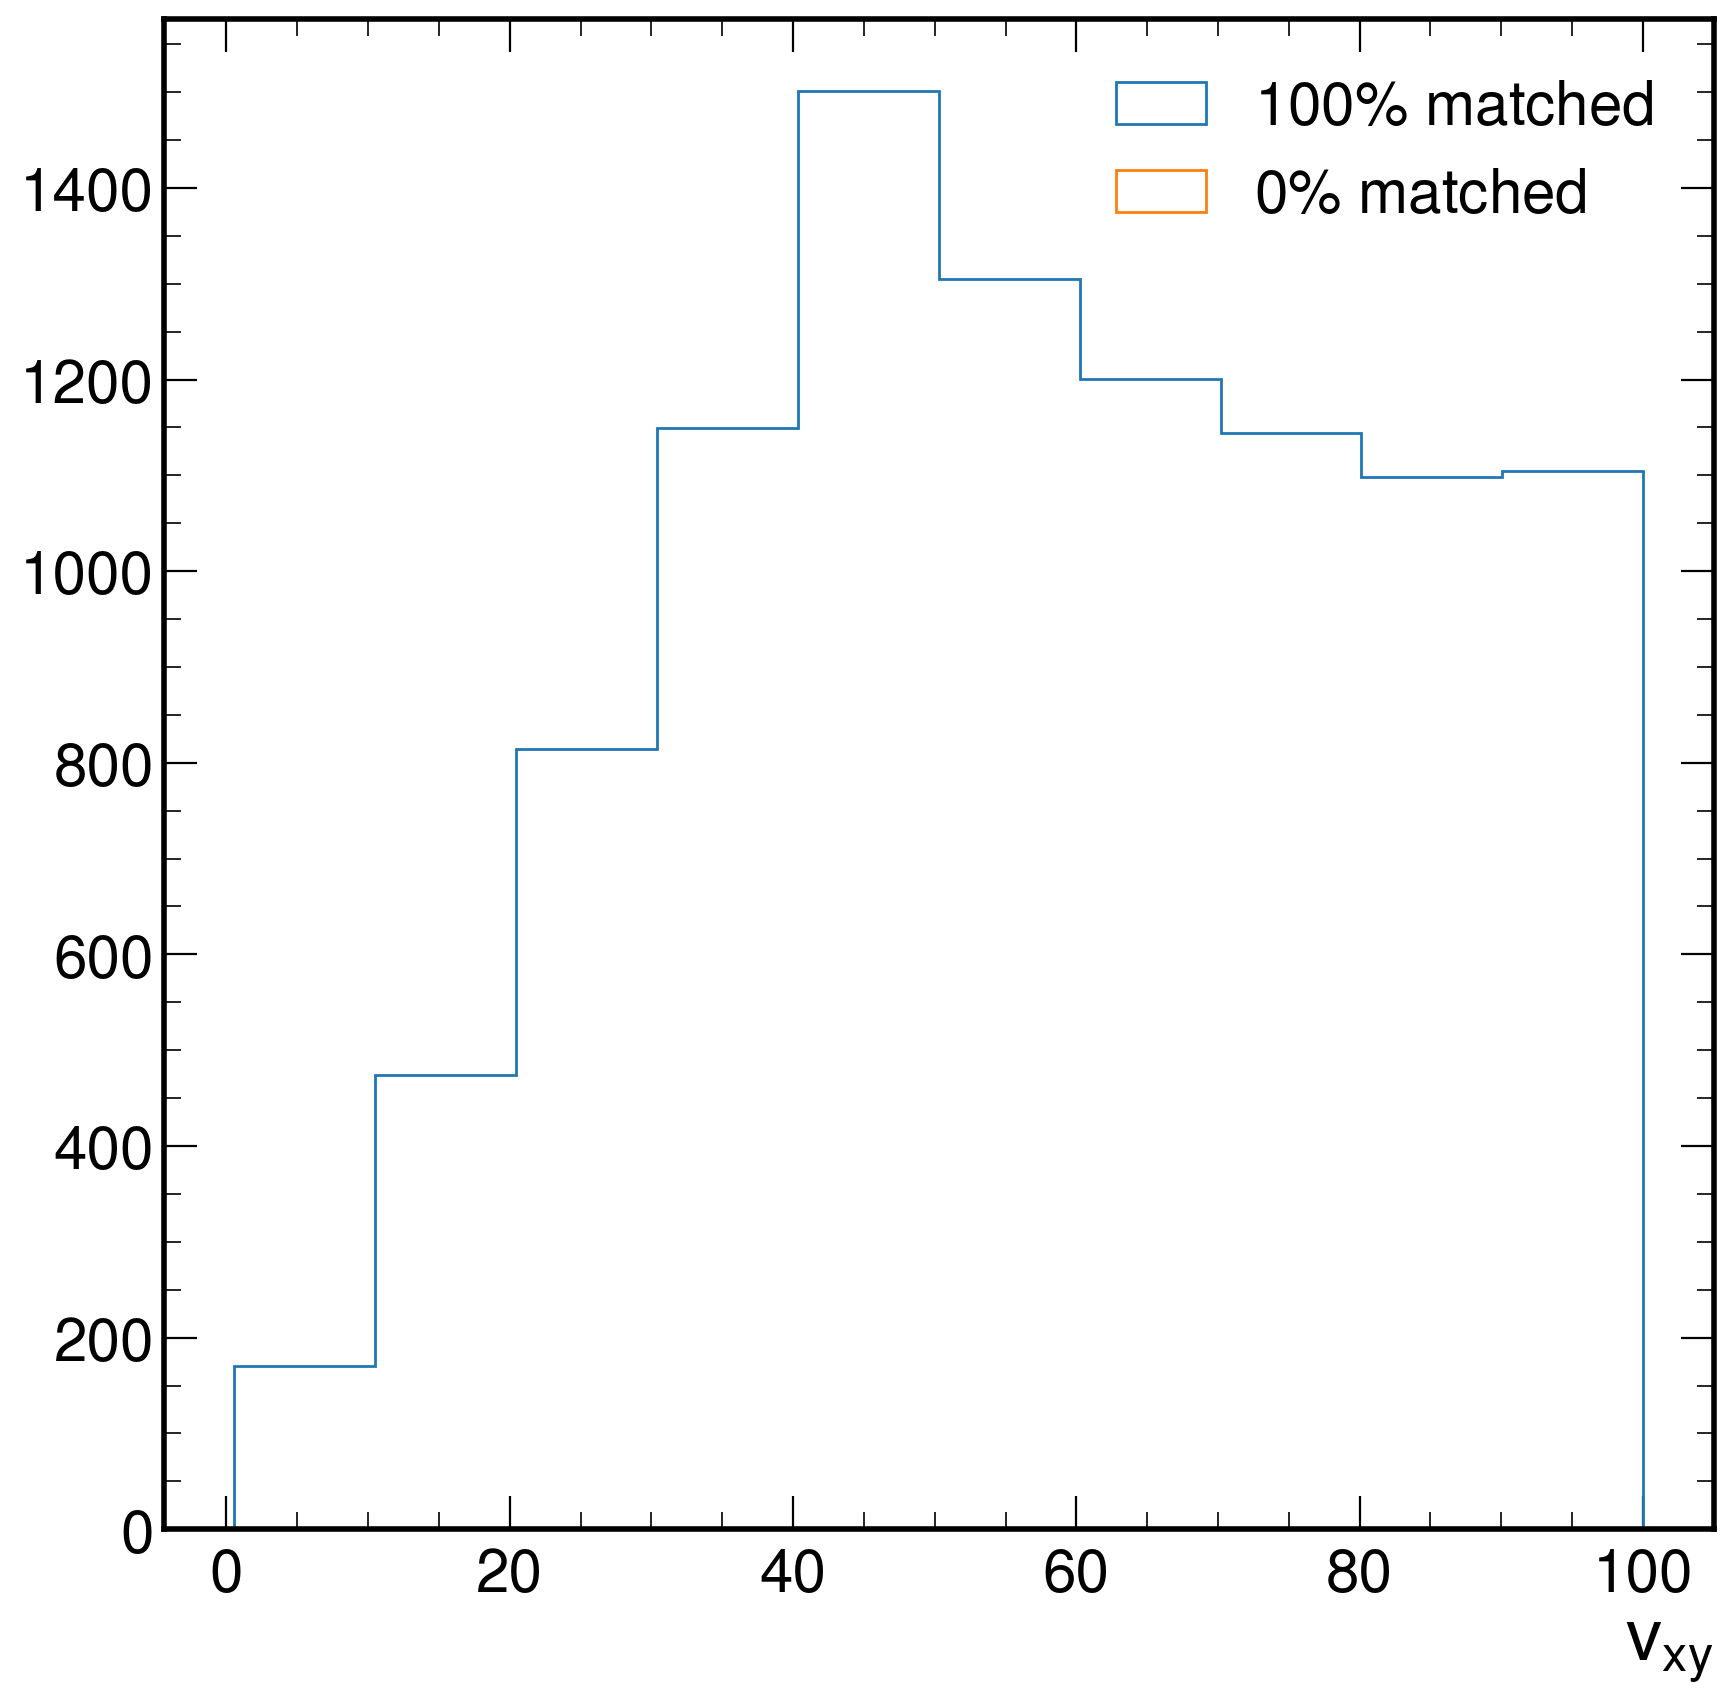

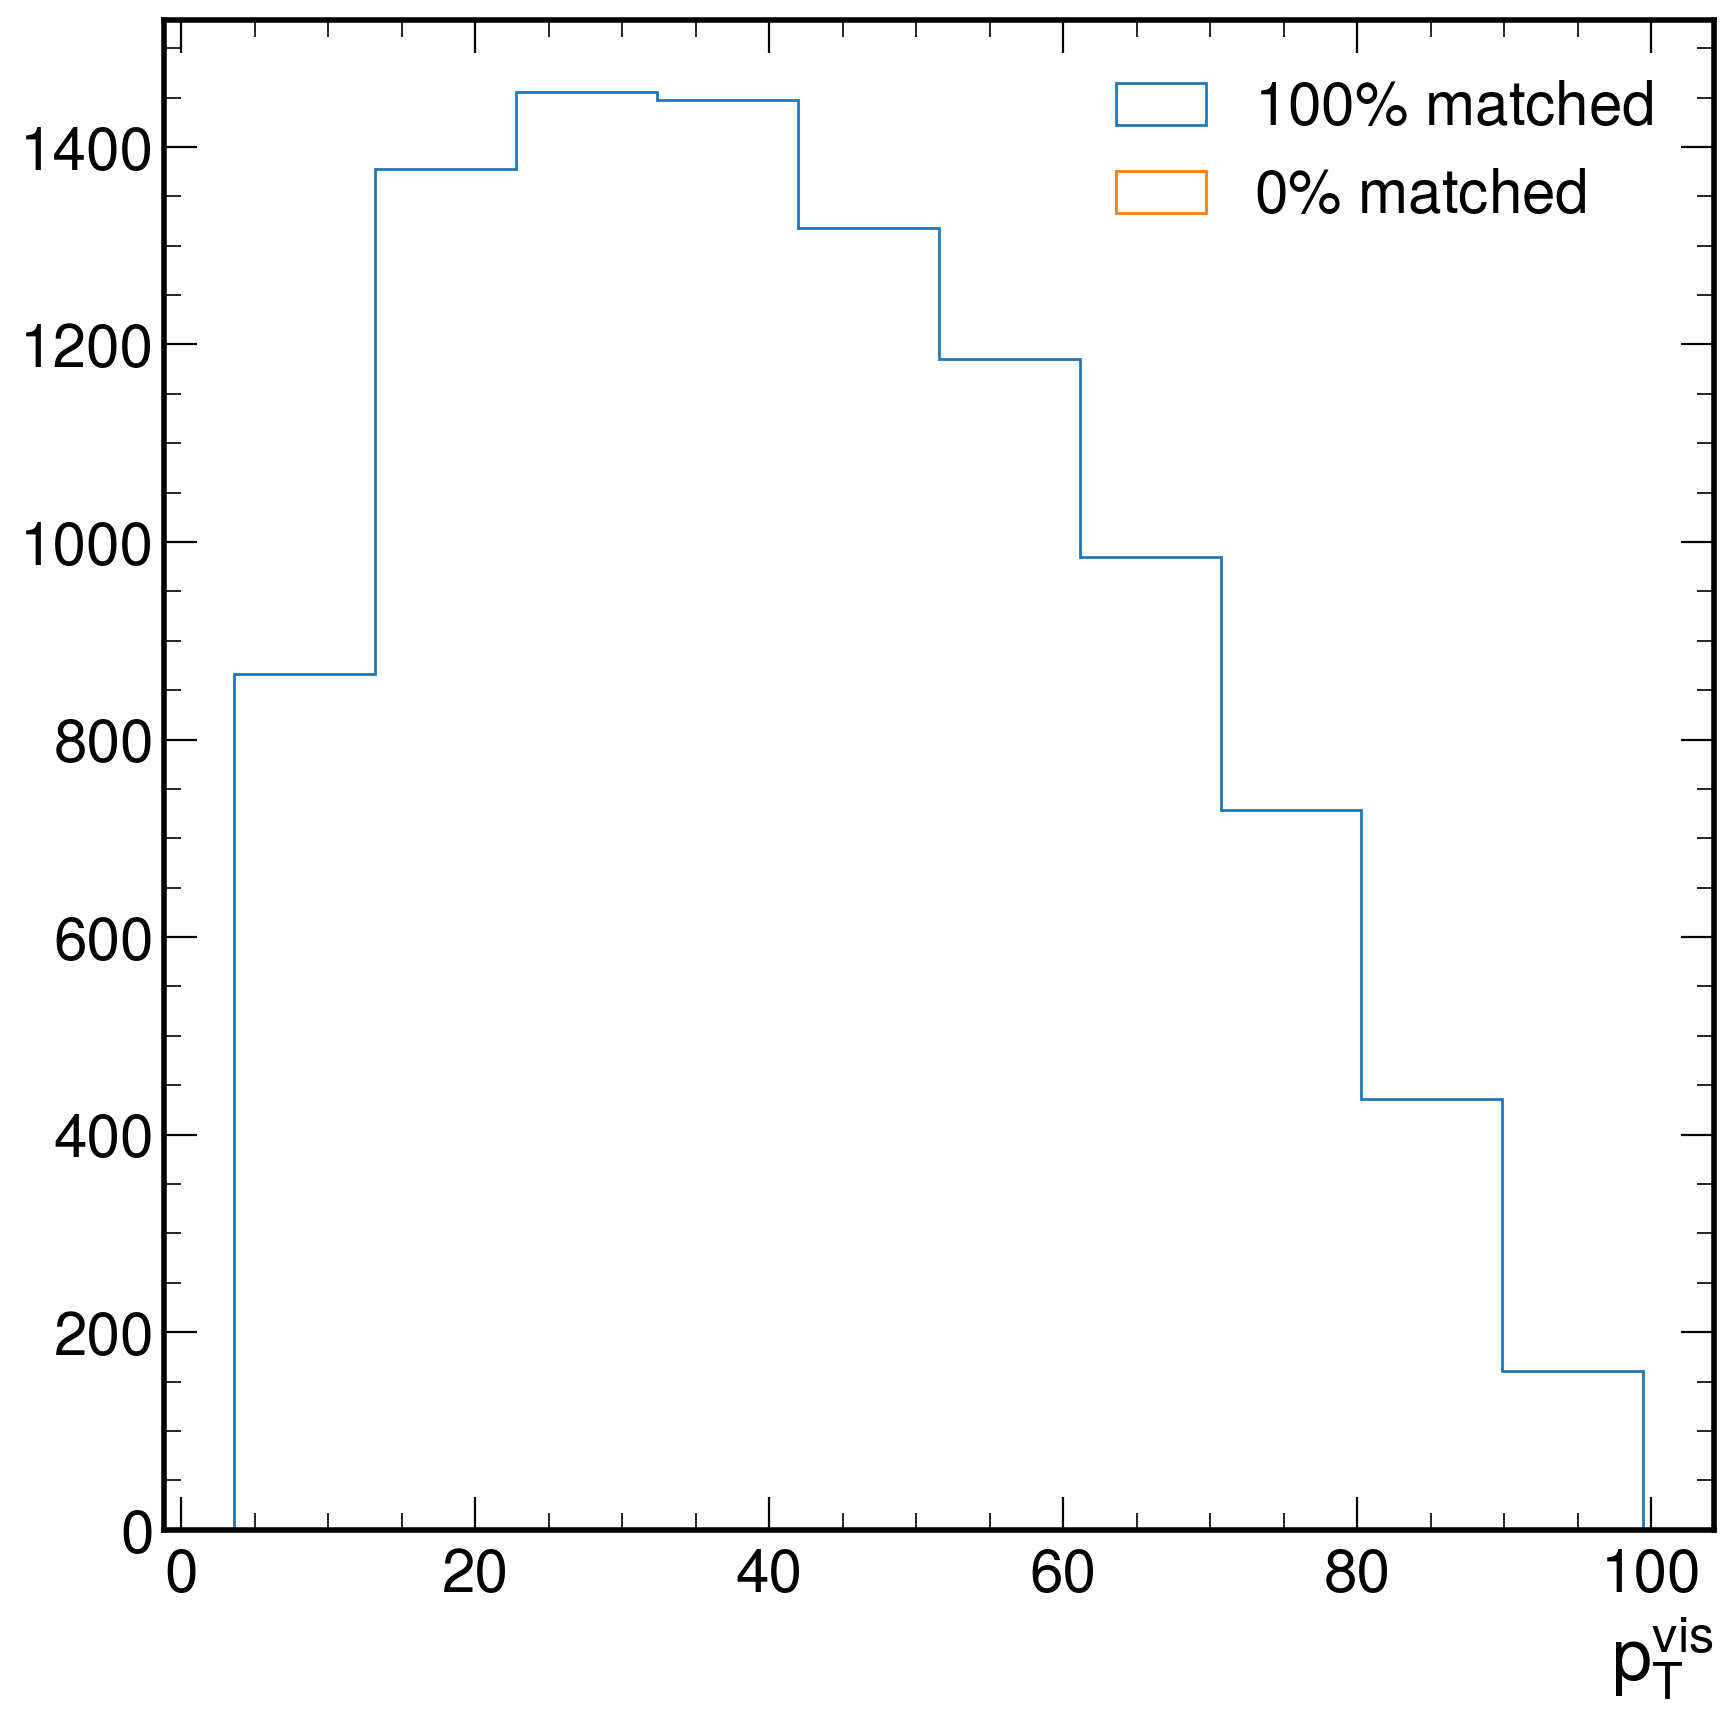

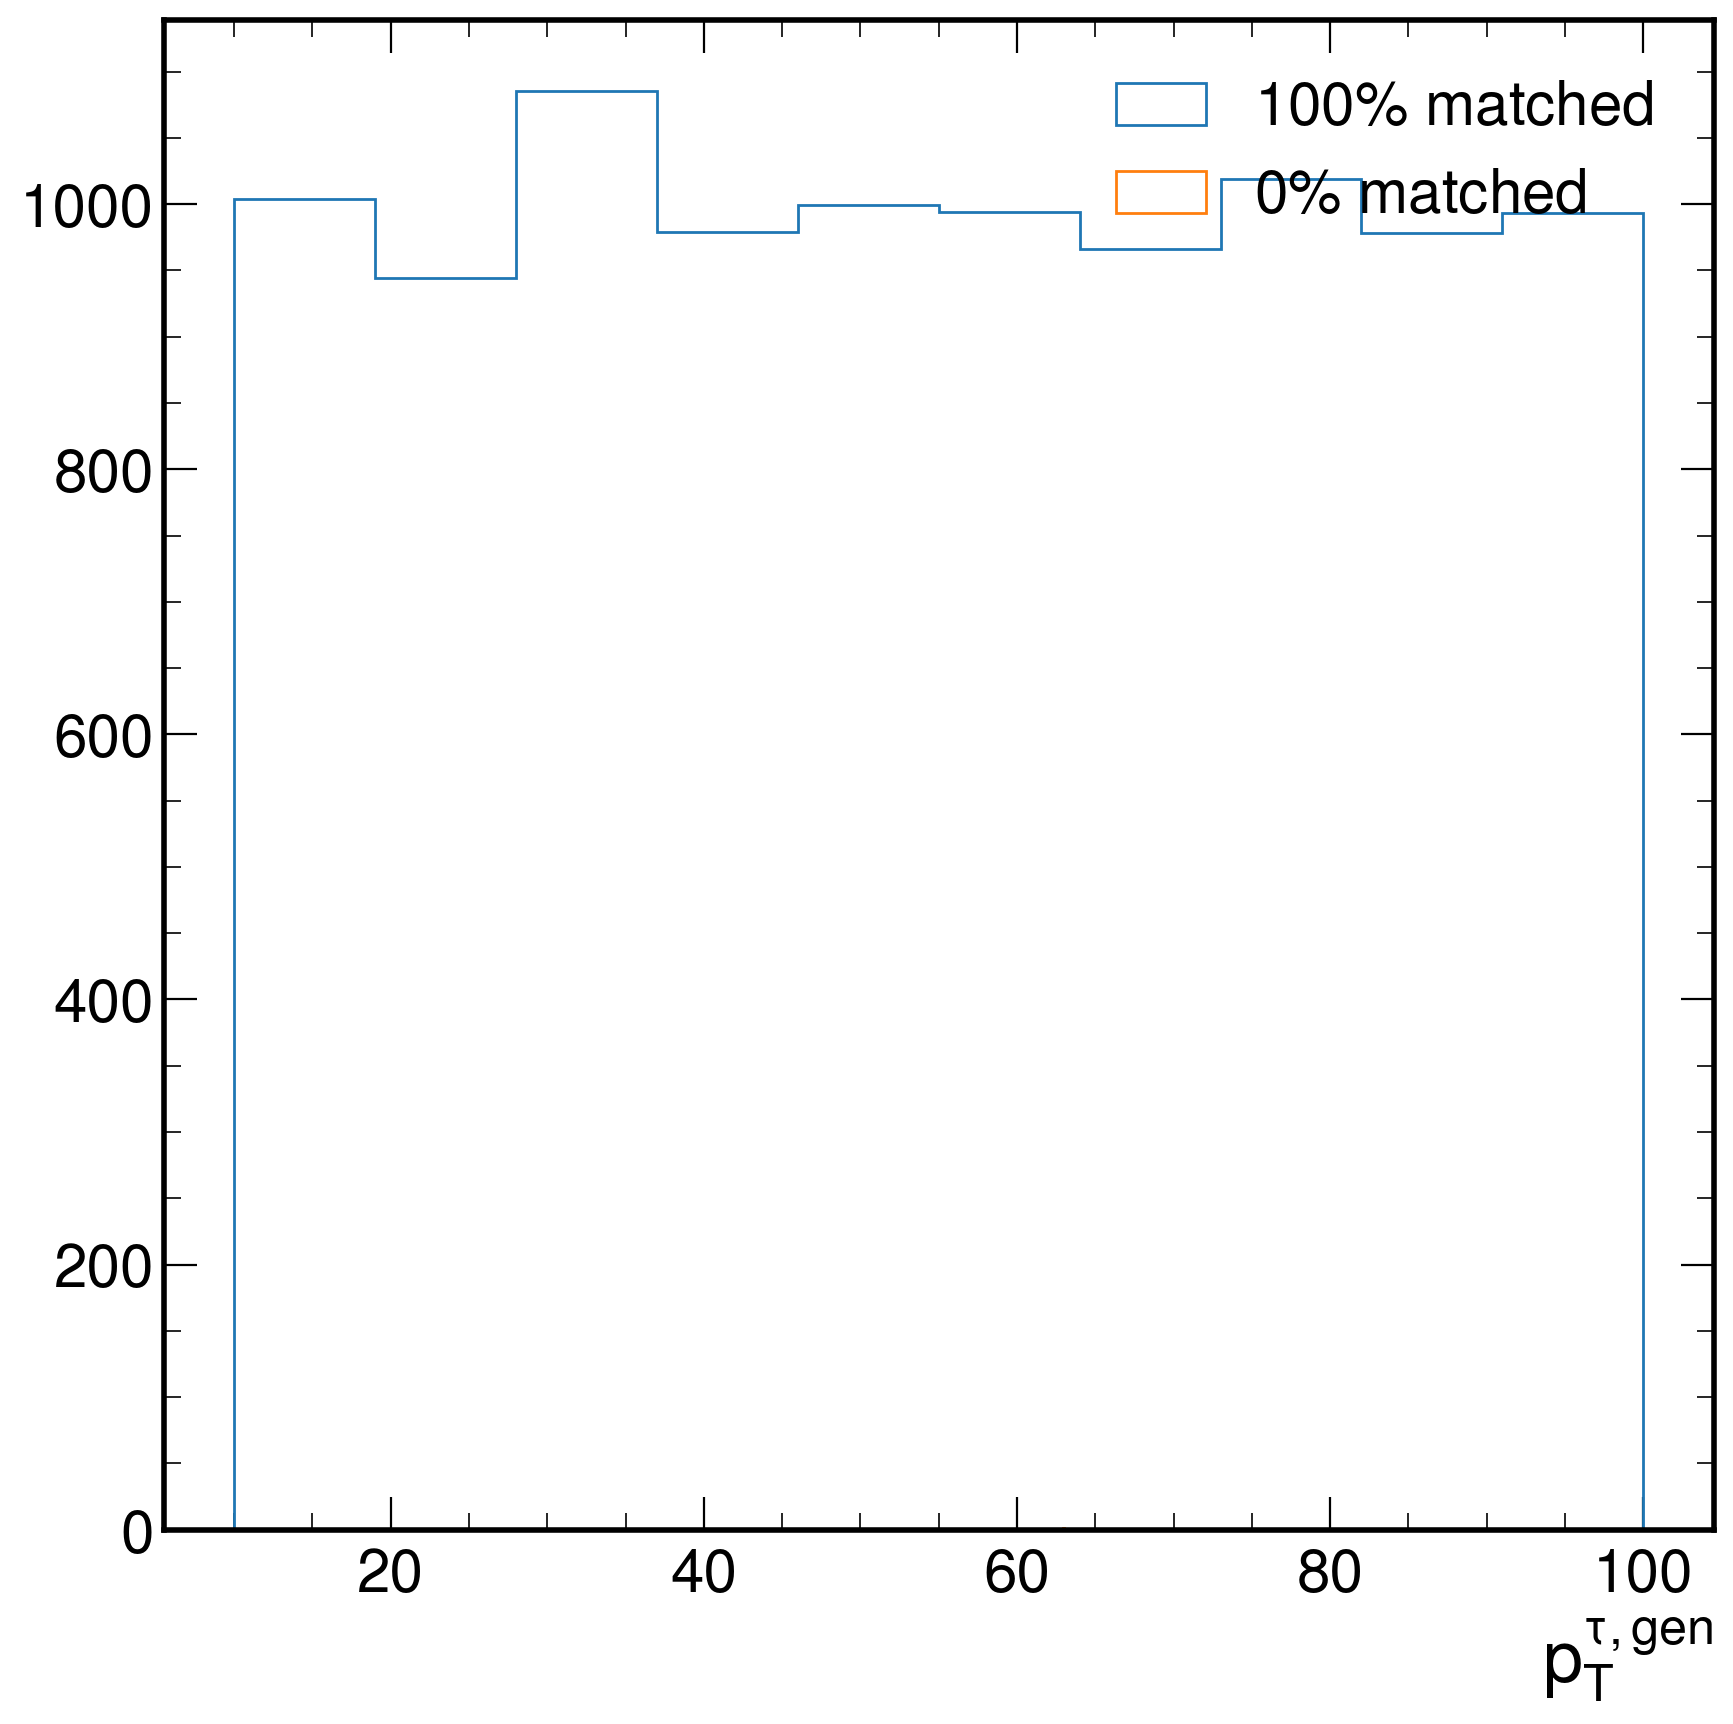

In [16]:
fig = plt.figure(dpi=200)
plt.hist(sim_effs, bins=25)
tenth = np.percentile(sim_effs, 10)
plt.axvline(x=tenth, color='red',
            label=f"{tenth:.3f} (10th %ile)")
twenty = np.percentile(sim_effs, 20)
plt.axvline(x=twenty, color='orange',
            label=f"{twenty:.3f} (20th %ile)")
thirty = np.percentile(sim_effs, 30)
plt.axvline(x=thirty, color='yellow',
            label=f"{thirty:.3f} (30th %ile)")
plt.legend(loc='best')
plt.xlabel('Sim-Hit Match Fraction')
plt.ylabel('Counts')
plt.show()

# relevant displacement variables 
vxy, vz = tau['vxy'], tau['vz']
v = np.sqrt(vxy**2 + vz**2)
fig, ax = plt.subplots(dpi=200)
h = plt.hist2d(vxy, sim_effs, bins=(20,20))
fig.colorbar(h[3], ax=ax)
ax.set_xlabel('$v_{xy}$')
ax.set_ylabel('Sim-Hit Match Fraction')
plt.show()

fig, ax = plt.subplots(dpi=200)
vis_pt = ak.sum(vis['pt'], axis=1)
h = plt.hist2d(vis_pt, sim_effs, bins=(20,20))
fig.colorbar(h[3], ax=ax)
ax.set_xlabel('$p_T^\mathrm{vis}$')
ax.set_ylabel('Sim-Hit Match Fraction')
plt.show()

cut = 0.828
mask = (np.array(sim_effs) > cut)
vxy_success = vxy[mask]
vxy_failure = vxy[~mask]
plt.figure(dpi=200)
plt.hist(vxy_success, histtype='step', label='$>83\%$ matched', density=False)
plt.hist(vxy_failure, histtype='step', label='$<83\%$ matched', density=False)
plt.legend(loc='best')
plt.xlabel('$v_{xy}$')
plt.show()

vis_pt = ak.sum(vis['pt'], axis=1)
mask = (np.array(sim_effs) > cut)
vis_pt_success = vis_pt[mask]
vis_pt_failure = vis_pt[~mask]
plt.figure(dpi=200)
plt.hist(vis_pt_success, histtype='step', label='$>83\%$ matched', density=False)
plt.hist(vis_pt_failure, histtype='step', label='$<83\%$ matched', density=False)
plt.legend(loc='best')
plt.xlabel('$p_T^\mathrm{vis}$')
plt.show()

tau_pt_success = tau['pt'][mask]
tau_pt_failure = tau['pt'][~mask]
plt.figure(dpi=200)
plt.hist(tau_pt_success, histtype='step', label='$>83\%$ matched', density=False)
plt.hist(tau_pt_failure, histtype='step', label='$<83\%$ matched', density=False)
plt.legend(loc='best')
plt.xlabel(r'$p_T^{\tau,\mathrm{gen}}$')
plt.show()

cut = 0.001
mask = (np.array(sim_effs) > cut)
vxy_success = vxy[mask]
vxy_failure = vxy[~mask]
plt.figure(dpi=200)
plt.hist(vxy_success, histtype='step', label='$100\%$ matched', density=False)
plt.hist(vxy_failure, histtype='step', label='$0\%$ matched', density=False)
plt.legend(loc='best')
plt.xlabel('$v_{xy}$')
plt.show()

vis_pt = ak.sum(vis['pt'], axis=1)
vis_pt_success = vis_pt[mask]
vis_pt_failure = vis_pt[~mask]
plt.figure(dpi=200)
plt.hist(vis_pt_success, histtype='step', label='$100\%$ matched', density=False)
plt.hist(vis_pt_failure, histtype='step', label='$0\%$ matched', density=False)
plt.legend(loc='best')
plt.xlabel('$p_T^\mathrm{vis}$')
plt.show()

tau_pt_success = tau['pt'][mask]
tau_pt_failure = tau['pt'][~mask]
plt.figure(dpi=200)
plt.hist(tau_pt_success, histtype='step', label='$100\%$ matched', density=False)
plt.hist(tau_pt_failure, histtype='step', label='$0\%$ matched', density=False)
plt.legend(loc='best')
plt.xlabel(r'$p_T^{\tau, \mathrm{gen}}$')
plt.show()



(array([1642., 1524., 1498., 1424., 1367., 1123.,  785.,  445.,  130.,
          24.]),
 array([1.3958354e-04, 8.1335306e-02, 1.6253103e-01, 2.4372676e-01,
        3.2492247e-01, 4.0611821e-01, 4.8731393e-01, 5.6850964e-01,
        6.4970541e-01, 7.3090112e-01, 8.1209683e-01], dtype=float32),
 [<matplotlib.patches.Polygon at 0x2b7668cca130>])

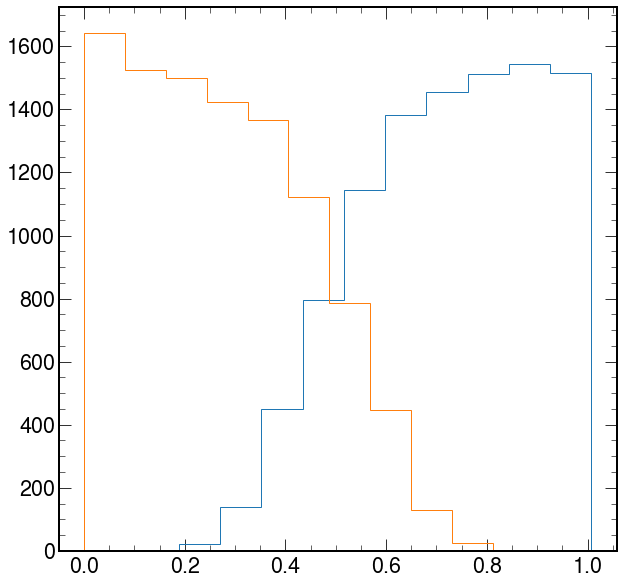

In [10]:
plt.hist(ak.sum(vis['pt'], axis=1)/tau['pt'], histtype='step')
plt.hist(ak.sum(inv['pt'], axis=1)/tau['pt'], histtype='step')

In [ ]:
# fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18,6), dpi=100)
        #plot_cluster(axs[0], df['ix_sim'].to_numpy(), df['iy_sim'].to_numpy(), df['energy_sim'].to_numpy())
        #plot_cluster(axs[1], df['ix_rec'].to_numpy(), df['iy_rec'].to_numpy(), df['energy_rec'].to_numpy())
        #plot_cluster(axs[2], df['ix_rec'][mask].to_numpy(), df['iy_rec'][mask].to_numpy(), 
        #             np.exp(df['energy_rec'][mask].to_numpy()))
        #xlim = [axs[0].get_xlim()[0]-5, axs[0].get_xlim()[1]+5]
        #ylim = [axs[0].get_ylim()[0]-5, axs[0].get_ylim()[1]+5]
        #axs[0].set_xlabel(ix)
        #axs[0].set_ylabel(iy)
        #axs[0].set_title(sd + ' sim_hits')
        #axs[1].set_xlim(xlim)
        #axs[1].set_xlabel(ix)
        #axs[1].set_ylabel(iy)
        #axs[1].set_ylim(ylim)
        #axs[1].set_title(sd + ' rec_hits')
        #axs[2].set_xlim(xlim)
        #axs[2].set_xlabel(ix)
        #axs[2].set_ylabel(iy)
        #axs[2].set_ylim(ylim)
        #axs[2].set_title(sd + ' rec_hits_true')
        #plt.tight_layout()
        #plt.show()
    